In [1]:
!gdown 18J_Z8b-qMMj9wm5eGyQ-1nPS16PfRePK

Downloading...
From: https://drive.google.com/uc?id=18J_Z8b-qMMj9wm5eGyQ-1nPS16PfRePK
To: /kaggle/working/VIC.csv
100%|██████████████████████████████████████| 66.8k/66.8k [00:00<00:00, 74.3MB/s]


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import matplotlib.dates as mdates

import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error,mean_absolute_error , r2_score
from sklearn.preprocessing import StandardScaler

In [3]:
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")
print(f"Device available:{'CUDA' if torch.cuda.is_available() else 'CPU'}")

#đọc data
df = pd.read_csv("VIC.csv")
print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['time'].min()} to {df['time'].max()}")

#xử lý và sắp xếp theo thời gian
df['time'] = pd.to_datetime(df['time'])
df = df.sort_values('time').reset_index(drop=True)

#thông tin cơ bản
print("\nFirst few rows:")
display(df.head())

print("\nData type:")
print(df.dtypes)

print("\nBasic statistics:")
display(df.describe())

Device available:CUDA
Dataset shape: (1500, 7)
Date range: 2020-08-03 to 2025-08-01

First few rows:


,time,open,high,low,close,volume,symbol
0,2020-08-03,77.33,78.31,75.56,77.87,164310,VIC
1,2020-08-04,78.84,78.84,77.69,78.22,229230,VIC
2,2020-08-05,78.22,78.67,75.38,77.33,434490,VIC
3,2020-08-06,78.22,78.40,77.42,77.78,332340,VIC
4,2020-08-07,77.87,78.40,77.60,77.78,182500,VIC



Data type:
time      datetime64[ns]
open             float64
high             float64
low              float64
close            float64
volume             int64
symbol            object
dtype: object

Basic statistics:


,time,open,high,low,close,volume
count,1500,1500.000000,1500.000000,1500.000000,1500.000000,1.500000e+03
mean,2023-05-31 20:30:43.200000,66.962047,67.855153,65.962507,66.945673,3.237043e+06
min,2020-08-03 00:00:00,39.700000,40.100000,38.700000,39.900000,9.045000e+04
25%,2022-01-25 18:00:00,43.350000,43.900000,42.887500,43.337500,1.416521e+06
50%,2023-07-31 12:00:00,59.700000,60.800000,58.200000,59.700000,2.085500e+06
75%,2024-10-29 06:00:00,91.560000,92.800000,89.347500,91.417500,3.419875e+06
max,2025-08-01 00:00:00,128.000000,129.690000,127.110000,128.000000,2.823433e+07
std,NaN,23.807897,24.240006,23.308936,23.787486,3.482834e+06


In [4]:
#tạo essential features
print("1. Tạo esential features:")
df["daily_return"] = df["close"].pct_change()
df["close_log"] = np.log(df["close"])
print(" - daily_return: phần trăm thay đổi hằng ngày")
print(" - close_log: log giá đóng cửa")

# kiểm tra mising values cho Tất Cả các cột
missing_infor = df.isnull().sum
# chỉ xử lý giá trị khuyết cần thiết
if df["daily_return"].isnull().sum() > 0:
    df["daily_return"].fillna(0, inplace=True)
# Kiểm tra lại sau khi xử lý
missing_after = df.isnull().sum()
missing_after

1. Tạo esential features:
 - daily_return: phần trăm thay đổi hằng ngày
 - close_log: log giá đóng cửa


time            0
open            0
high            0
low             0
close           0
volume          0
symbol          0
daily_return    0
close_log       0
dtype: int64

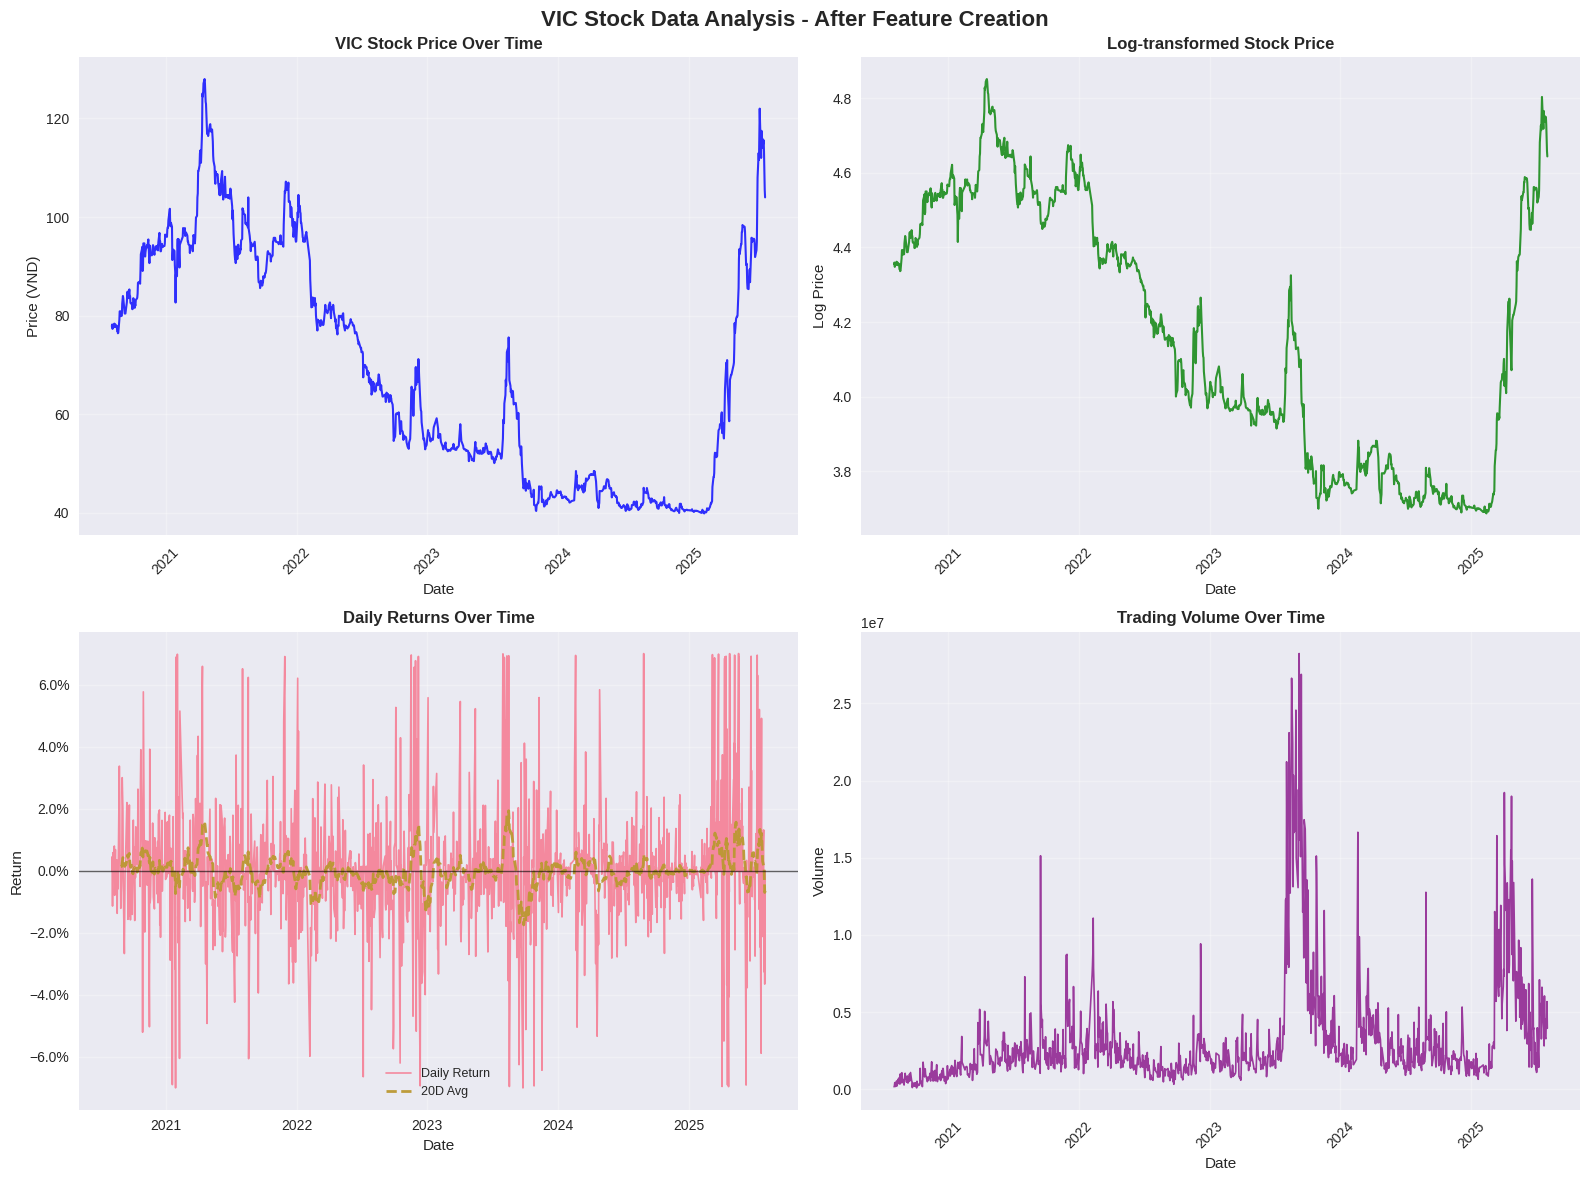

In [5]:
fig, axes = plt.subplots(2,2,figsize =(16,12))
fig.suptitle("VIC Stock Data Analysis - After Feature Creation", fontsize=16,
            fontweight="bold")

#1) Stock Price Over Time
axes[0,0].plot(df["time"], df["close"], linewidth=1.5 , color="blue" , alpha=0.8)
axes[0,0].set_title("VIC Stock Price Over Time", fontsize = 12, fontweight="bold")
axes[0,0].set_xlabel("Date")
axes[0,0].set_ylabel("Price (VND)")
axes[0,0].grid(True,alpha= 0.3)
axes[0,0].tick_params(axis="x", rotation= 45)

#2) Log-stransformed Price
axes[0,1].plot(df["time"], df["close_log"], linewidth=1.5 , color="green" , alpha=0.8)
axes[0,1].set_title("Log-transformed Stock Price", fontsize = 12, fontweight="bold")
axes[0,1].set_xlabel("Date")
axes[0,1].set_ylabel("Log Price")
axes[0,1].grid(True,alpha= 0.3)
axes[0,1].tick_params(axis="x", rotation= 45)

# 3) Daily Returns Over Time
ret_ts = df[["time", "daily_return"]].dropna().copy()
ret_ts["ret_ma20"] = ret_ts["daily_return"].rolling(20).mean()

axes[1,0].plot(ret_ts["time"], ret_ts["daily_return"], linewidth=1.2 , alpha = 0.8, label="Daily Return")
axes[1,0].plot(ret_ts["time"] , ret_ts["ret_ma20"] , linewidth = 2.0 , linestyle="--",alpha = 0.95 , label="20D Avg")

axes[1,0].axhline(0, color="black", linewidth=1, alpha=0.6)
axes[1,0].set_title("Daily Returns Over Time", fontsize= 12 , fontweight="bold")
axes[1,0].set_xlabel("Date")
axes[1,0].set_ylabel("Return")
axes[1, 0].yaxis.set_major_formatter(PercentFormatter(1.0))
axes[1, 0].xaxis.set_major_locator(mdates.AutoDateLocator())
axes[1, 0].xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))

axes[1, 0].tick_params(axis="x", rotation=0)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend(fontsize=9)

#4) Volume Over Time
axes[1, 1].plot(df["time"], df["volume"], linewidth=1.2, color="purple", alpha=0.75)
axes[1, 1].set_title("Trading Volume Over Time", fontsize=12, fontweight="bold")
axes[1, 1].set_xlabel("Date")
axes[1, 1].set_ylabel("Volume")
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].tick_params(axis="x", rotation=45)
plt.tight_layout()
plt.show()

#dataloader

In [6]:
# Univariate Time Series Dataset for 7-day prediction
class UnivariateTimeSeriesDataset(Dataset):
    """Dataset for univariate time series forecasting - 7 days ahead"""
    def __init__(self, data, seq_len, pred_len=7, target_col='close', normalize=False):
        self.data = data.dropna().reset_index(drop=True)
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.target_col = target_col
        self.normalize = normalize

        self.series = self.data[target_col].values

        if normalize:
            self.mean = np.mean(self.series)
            self.std = np.std(self.series)

    def __len__(self):
        return len(self.series) - self.seq_len - self.pred_len + 1

    def __getitem__(self, idx):
        x = self.series[idx:idx+self.seq_len].copy()
        y = self.series[idx+self.seq_len:idx+self.seq_len+self.pred_len].copy()

        if self.normalize:
            x = (x - self.mean) / self.std
            y = (y - self.mean) / self.std

        return torch.FloatTensor(x), torch.FloatTensor(y)

    def denormalize(self, normalized_values):
        if not self.normalize:
            return normalized_values
        return normalized_values * self.std + self.mean

def create_univariate_datasets(df, seq_lengths, pred_len=7, target_col='close'):
    """Create univariate datasets for different sequence lengths"""
    datasets = {}

    for seq_len in seq_lengths:
        dataset = UnivariateTimeSeriesDataset(
            data=df, seq_len=seq_len, pred_len=pred_len,
            target_col=target_col, normalize=False
        )
        datasets[f'{seq_len}d'] = dataset

    return datasets

# Create datasets for 7-day prediction with new input lengths
seq_lengths = [7, 30, 120, 480]  # Updated input lengths
pred_len = 7  # Predict 7 days ahead

# Create datasets using log prices for better stability
datasets = create_univariate_datasets(df, seq_lengths, pred_len, 'close_log')

print(f"Created datasets for 7-day prediction with input lengths: {seq_lengths}")
for name, dataset in datasets.items():
    print(f"- {name}: {len(dataset)} samples")

print(f"Using log-transformed prices for stability.")

Created datasets for 7-day predict with input lengths: [7, 30, 120, 480]
-7d: 1487 samples
-30d: 1464 samples
-120d: 1374 samples
-480d: 1014 samples
Using log-transformed prices for stability


In [7]:
def create_time_based_splits(dataset, train_ratio = 0.7 , val_ratio= 0.15):
    """Create time-based splits for time series data"""
    total_len = len(dataset)
    train_len = int(total_len * train_ratio)
    val_len = int(total_len * val_ratio)
    # Time-based splits (no shuffling to preserve temporal order)
    train_indices = list(range(0, train_len))
    val_indices = list(range(train_len, train_len + val_len))
    test_indices = list(range(train_len + val_len , total_len))

    train_dataset = torch.utils.data.Subset(dataset , train_indices)
    val_dataset = torch.utils.data.Subset(dataset , val_indices)
    test_dataset = torch.utils.data.Subset(dataset , test_indices)

    return train_dataset , val_dataset , test_dataset

# Create splits for all sequence lengths
data_splits = {}
print("Creating time-based data splits:")
print("- Train: 70%, Validation: 15%, Test: 15%")
print("- Temporal order preserved (no shuffling)")

for seq_name , dataset in datasets.items():
    train, val ,test = create_time_based_splits(dataset)
    data_splits[seq_name] = {
        "train":train,
        "val":val,
        "test":test
    }
print(f"\nTotal datasets with splits: {len(data_splits)}")
# Verify split integrity
# print(f"\n=== SPLIT VERIFICATION ===")
# for seq_name , splits in data_splits.item():
#     total_samples = len(splits["train"]) + len(splits["val"]) + len(splits["test"])
#     original_samples = len(datasets[seq_name])
    
#     print(f"{seq_name}: {total_samples}/{original_samples} samples")
#         if total_samples == original_samples
#         else f"{seq_name}: ERRO - {total_samples}/{original_samples}"
# print("\nData splits created successfully!")

Creating time-based data splits:
- Train: 70%, Validation: 15%, Test: 15%
- Temporal order preserved (no shuffling)

Total datasets with splits: 4


In [72]:
# LTSF-Linear Models Implementation for Univariate Time Series (7-day prediction)
class Linear(nn.Module):
    """Simple Linear model for univariate time series forecasting"""
    def __init__(self, seq_len, pred_len = 7):
        super(Linear , self).__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.linear = nn.Linear(seq_len , pred_len)
    
    def forward(self , x):
        # x: [batch_size, seq_len] - historical prices
        # Output: [batch_size, pred_len] - 7-day future predictions
        return self.linear(x)

class DLinear(nn.Module):
    """Decomposition Linear for univariate time series - handles trend and seasonality"""
    def __init__(self,seq_len , pred_len = 7 , moving_avg = 5):
        super(DLinear , self).__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.moving_avg = min(moving_avg , seq_len - 1)
        # Linear layers for trend and seasonal components

        self.linear_trend = nn.Linear(self.seq_len , self.pred_len)
        self.linear_seasonal = nn.Linear(self.seq_len , self.pred_len)
        # Create moving average kernel for trend extraction
        self.register_buffer('avg_kernel', torch.ones(1, 1, self.moving_avg)/ self.moving_avg)

    def decompose(self, x):
        """Decompose series into trend and seasonal components"""
        batch_size , seq_len = x.shape # x: [batch_size, seq_len] - historical prices
        x_reshaped = x.unsqueeze(1) #(N, C, L)

        #Apply moving average for trend
        padding = self.moving_avg // 2
        x_padded = torch.nn.functional.pad(x_reshaped , (padding, padding), mode='replicate')

        trend = torch.nn.functional.conv1d(x_padded, self.avg_kernel , padding = 0)
        trend = trend.squeeze(1)
        # trend[B,C,L]
        # Ensure trend has same length as input
        if trend.shape[1] != seq_len:
            trend = torch.nn.functional.interpolate(
                trend.unsqueeze(1) , size = seq_len , mode='linear', align_corners=False
            ).squeeze(1)
        seasonal = x - trend
        return trend , seasonal

    def forward(self,x):
        trend , seasonal = self.decompose(x)
        trend_pred = self.linear_trend(trend)
        seasonal_pred = self.linear_seasonal(seasonal)
        pred = seasonal_pred + trend_pred
        return pred
class NLinear(nn.Module):
    """Normalized Linear for univariate time series - handles distribution shift"""
    def __init__(self, seq_len , pred_len = 7 ):
        super(NLinear , self).__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.linear = nn.Linear(self.seq_len , self.pred_len)

    def forward(self, x):
        # Normalize by subtracting last value
        last_value = x[:,-1:]
        x_normalize = x - last_value
        pred_normalized  = self.linear(x_normalize)
        pred_normalized += last_value
        return pred_normalized

print("LTSF-Linear models implemented for 7-day univariate forecasting.")

LTSF-Linear models implemented for 7-day univariate forecasting.


In [73]:
# Model Configuration and Creation for 7-day Prediction
horizon_configs={
    '7d':{'seq_len':7,'pred_len':7},
    '30d':{'seq_len':30,'pred_len':7},
    '120d':{'seq_len':120,'pred_len':7},
    '480d':{'seq_len':480,'pred_len':7}
}

# Create model instances for each combination

model_configs={
    'Linear':{},
    'DLinear':{},
    'NLinear':{}
}

print("Creating model instances for 7-day prediction:")
for horizon , config in horizon_configs.items():
    seq_len = config['seq_len']
    pred_len = config['pred_len']

    #Create model instances
    model_configs['Linear'][horizon]={
        'model': Linear(seq_len , pred_len),
        'seq_len': seq_len,
        'pred_len': pred_len
    }

    model_configs['DLinear'][horizon]={
        'model': DLinear(seq_len , pred_len),
        'seq_len': seq_len,
        'pred_len': pred_len
    }

    model_configs['NLinear'][horizon]={
        'model': NLinear(seq_len , pred_len),
        'seq_len': seq_len,
        'pred_len': pred_len
    }
    print(f" {horizon}: seq_len={seq_len}, pred_len={pred_len}")

Creating model instances for 7-day prediction:
 7d: seq_len=7, pred_len=7
 30d: seq_len=30, pred_len=7
 120d: seq_len=120, pred_len=7
 480d: seq_len=480, pred_len=7


#tranning

In [74]:
# Training Configuration with Data Normalization for 7-day Prediction
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Create normalized dataset class
class NormalizedDataset(Dataset):
    def __init__(self, original_dataset , scaler = None):
        self.original_dataset = original_dataset

        #Fit scaler if not provided
        if scaler is None:
            all_data =[]
            for i in range(len(original_dataset)):
                x , y = original_dataset[i]
                all_data.extend(x.numpy())
                all_data.extend(y.numpy())
            self.scaler = StandardScaler()
            #(n_samples,n_features)
            self.scaler.fit(np.array(all_data).reshape(-1,1))
        else:
            self.scaler=scaler

    def __len__(self):
         return len(self.original_dataset)

    def __getitem__(self, idx):
        x , y = self.original_dataset[idx]

        # Normalize features and targets
        x_norm = self.scaler.transform(x.numpy().reshape(-1,1)).flatten()
        y_norm = self.scaler.transform(y.numpy().reshape(-1,1)).flatten()

        return torch.FloatTensor(x_norm), torch.FloatTensor(y_norm)

    def denormalize(self , normalized_values):
        """Convert normalized values back to original scale"""
        return self.scaler.inverse_transform(normalized_values.reshape(-1,1)).flatten()

# Create normalized datasets
normalized_datasets = {}
scaler = None

for horizon , dataset in datasets.items():
    normalized_dataset = NormalizedDataset(dataset,scaler)
    if scaler is None:
        scaler = normalized_dataset.scaler #Use same scaler for all
    normalized_datasets[horizon] = normalized_dataset

#Create normalized splits
normalized_data_splits = {}
for horizon in datasets.keys():
    total_len = len(normalized_datasets[horizon])
    train_len = int(total_len * 0.7)
    val_len = int(total_len *0.15)

    train_indices = list(range(0,train_len))
    val_indices = list(range(train_len , train_len + val_len))
    test_indices = list(range(train_len + val_len , total_len))

    normalized_data_splits[horizon] ={
        'train': torch.utils.data.Subset(normalized_datasets[horizon] , train_indices),
        'val': torch.utils.data.Subset(normalized_datasets[horizon] , val_indices),
        'test': torch.utils.data.Subset(normalized_datasets[horizon] , test_indices)
    }

#Updated evaluation function for normalized data
def evaluate_model_normalized(model , test_loader , scaler , device='cuda'):
    model.to(device)
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for batch_x , batch_y in test_loader:
            batch_x , batch_y = batch_x.to(device) , batch_y.to(device)
            outputs = model(batch_x)
            
            # Denormalize predictions and actuals
            for i in range(outputs.shape[0]):
                pred_denorm = scaler.inverse_transform(outputs[i].cpu().numpy().reshape(-1,1)).flatten()
                actual_denorm = scaler.inverse_transform(batch_y[i].cpu().reshape(-1,1)).flatten()
                predictions.extend(pred_denorm)
                actuals.extend(actual_denorm)

    predictions=np.array(predictions)
    actuals = np.array(actuals)
    # Calculate metrics on original scale
    mse = mean_squared_error(actuals , predictions)
    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mse)

    try:
        r2 = r2_score(actuals , predictions)
    except:
        r2 = -999
    return {
        'mse': mse,
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'predictions': predictions,
        'actuals': actuals
    }

In [75]:
def train_model(model , train_loader, val_loader, num_epochs = 50 , lr=0.001, device="cuda"):
    """Train one model and return epoch-wise train/val MSE (no printing)."""
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 20 , gamma=0.5)

    model.to(device)
    train_losses , val_losses = [] , []

    for _ in range(num_epochs):
        #Train
        model.train()
        epoch_train = 0.0
        for batch_x, batch_y in train_loader:
            batch_x , batch_y = batch_x.to(device) , batch_y.to(device)
            optimizer.zero_grad()
            preds = model(batch_x)
            loss = criterion(preds , batch_y)
            loss.backward()
            optimizer.step()
            epoch_train += loss.item()
            #loss mean for each epochs
        train_losses.append(epoch_train / max(1,len(train_loader)))


        #Validata
        model.eval()
        epoch_val = 0.0
        with torch.no_grad():
            for batch_x , batch_y in val_loader:
                batch_x , batch_y = batch_x.to(device), batch_y.to(device)
                preds = model(batch_x)
                epoch_val += criterion(preds , batch_y).item()
            val_losses.append(epoch_val / max(1,len(val_loader)))
            scheduler.step()
    return model , train_losses , val_losses

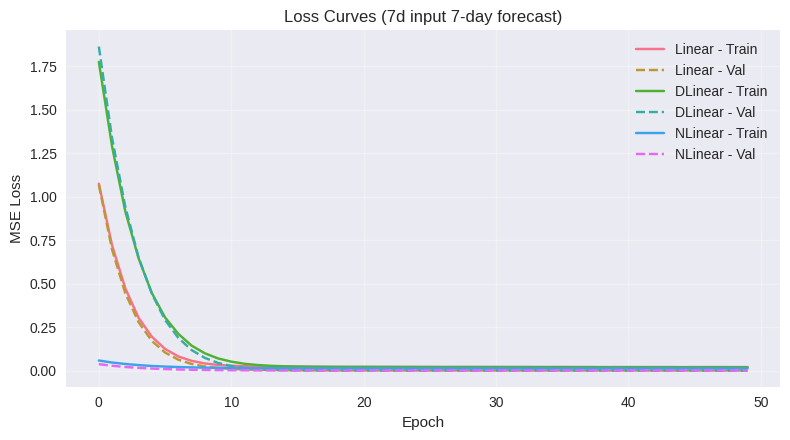

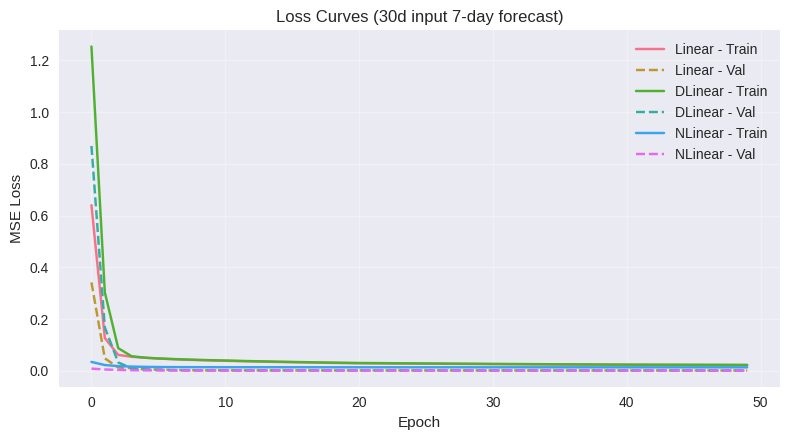

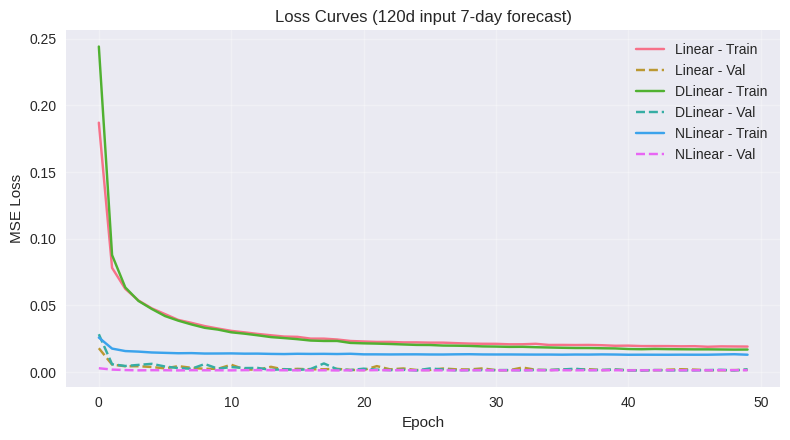

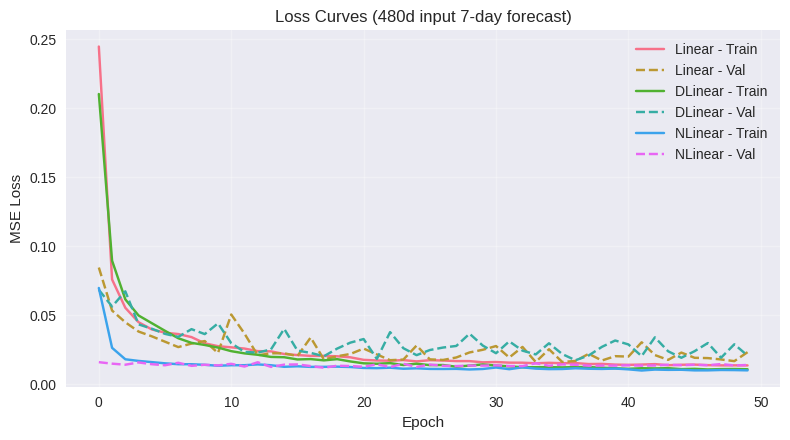

In [76]:
import matplotlib.pyplot as plt


# Hàm vẽ đồ thị loss
def plot_loss_curves(loss_history, horizons):
    """Plot train/val losses for all models across horizons."""
    for hz in horizons:
        plt.figure(figsize=(8, 4.5))
        for model_name in ["Linear", "DLinear", "NLinear"]:
            if hz in loss_history.get(model_name, {}):
                tl = loss_history[model_name][hz]["train"]
                vl = loss_history[model_name][hz]["val"]
                plt.plot(tl, label=f"{model_name} - Train")
                plt.plot(vl, linestyle="--", label=f"{model_name} - Val")
        plt.title(f"Loss Curves ({hz} input 7-day forecast)")
        plt.xlabel("Epoch")
        plt.ylabel("MSE Loss")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()

# Hyperparameters
batch_size = 32
num_epochs = 50
learning_rate = 0.001

# Dictionary lưu kết quả
results = {"Linear": {}, "DLinear": {}, "NLinear": {}}
trained_models = {"Linear": {}, "DLinear": {}, "NLinear": {}}
loss_history = {"Linear": {}, "DLinear": {}, "NLinear": {}}

# Lặp qua các horizon (dài input khác nhau)
for horizon in ["7d", "30d", "120d", "480d"]:
    # Tạo DataLoader cho train/val/test
    train_loader = DataLoader(
        normalized_data_splits[horizon]["train"],
        batch_size=batch_size, shuffle=True, drop_last=True
    )
    val_loader = DataLoader(
        normalized_data_splits[horizon]["val"],
        batch_size=batch_size, shuffle=False, drop_last=True
    )
    test_loader = DataLoader(
        normalized_data_splits[horizon]["test"],
        batch_size=batch_size, shuffle=False, drop_last=True
    )

    # Lặp qua từng model
    for model_name in ["Linear", "DLinear", "NLinear"]:
        model = model_configs[model_name][horizon]["model"]
        trained_model, tr_losses, va_losses = train_model(
            model, train_loader, val_loader,
            num_epochs=num_epochs, lr=learning_rate, device=device
        )

        # Lưu loss history và model đã train
        loss_history[model_name][horizon] = {"train": tr_losses, "val": va_losses}
        trained_models[model_name][horizon] = trained_model

        # Đánh giá model trên test set
        test_results = evaluate_model_normalized(trained_model, test_loader, scaler, device)
        results[model_name][horizon] = test_results

# Vẽ đồ thị loss
plot_loss_curves(loss_history, horizons=["7d", "30d", "120d", "480d"])


In [67]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


#save

In [77]:
torch.save(trained_model.state_dict(), "linear_7d_state_dict.pth")


In [82]:

seq_len = 480
pred_len = 7
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = Linear(seq_len, pred_len).to(device)

# Load state_dict
model.load_state_dict(torch.load('/kaggle/working/linear_7d_state_dict.pth', map_location=device))
model.eval()

import numpy as np
last_seq = np.log(df['close'].values[-seq_len:])  # lấy seq_len ngày gần nhất
x = scaler.transform(last_seq.reshape(-1,1)).flatten()
x_tensor = torch.FloatTensor(x).unsqueeze(0).to(device)  # shape [1, seq_len]


with torch.no_grad():
    y_pred = model(x_tensor).cpu().numpy().flatten()

# Denormalize và chuyển về giá gốc
y_pred_denorm = scaler.inverse_transform(y_pred.reshape(-1,1)).flatten()
y_pred_price = np.exp(y_pred_denorm)

print("Dự đoán 7 ngày tiếp theo:", y_pred_price)


Dự đoán 7 ngày tiếp theo: [61.80362  60.83146  60.90129  60.51152  62.33161  65.4211   62.874218]
